In [7]:
import sys
sys.path.append("..")
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch as t
device = t.device("cuda" if t.cuda.is_available() else "cpu")
from lib import Llama_Leaner, generate_data, CachedDataset
import seaborn as sns

In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

/root/miniconda/envs/my_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
prompt_dict = dict(
    system_prompt="Please answer the following question",
    # fmt: off
    user_prompt=lambda sentence, concept, token: ["In the sentence: >", sentence,"< is >",token,"< a " ,concept,"? "],
    # fmt: on
    ai_answer="Answer: ",
    yes_answer="Yes",
    no_answer="No",
)
prompt_function = CachedDataset.PromptUtil.add_syntax_to_prompt_func(prompt_dict)

pet_id = t.tensor(tokenizer.encode(" pet"))

In [10]:
sentences = ["the dog sat in the deep deep fog","the cat sat on the mat"]
data = tokenizer.batch_encode_plus(sentences, return_tensors="pt", padding=True).input_ids
labels = (data == 3797) + (data == 3290)
print(data.shape)

torch.Size([2, 8])


In [11]:
comparison_logit_set = []
comparison_cache_set = []
for sentence in data:
    for token in sentence:
        
        prompt = prompt_function(sentence, pet_id, token)
        # make all tensors in the prompt list to string, without trying to decode strings
        str_prompt = [tokenizer.decode(p) if isinstance(p, t.Tensor) else p for p in prompt]
        token_prompt =[tokenizer.encode(p) if isinstance(p, str) else p for p in str_prompt]
        token_prompt = [item for sublist in token_prompt for item in sublist]
        attention_mask = t.ones(len(token_prompt))
        print
        attention_mask[token_prompt == tokenizer.pad_token_id] = 0
        #print(prompt)
        print("".join(str_prompt))
        print("##################")

        output_comparison = model(
                input_ids=t.tensor(token_prompt).unsqueeze(0).to(device),
                attention_mask=attention_mask,
                return_dict=True,
            )
        
        comparison_logit_set.append(output_comparison.logits[0, -1, :])
        comparison_cache_set.append(output_comparison.past_key_values[0][0][0])

IndexError: too many indices for tensor of dimension 2

In [8]:
dataset = CachedDataset.CachedDataset(
    model, tokenizer, data, labels, prompt_dict, sentence_cache_device=device
)

In [9]:
config = Llama_Leaner.Config()
config.magic_word = "magic"
config.loss_coeffs = {"label": 1.0, "kl": 0.2, "entropy": 0.2}
config.lr = 0.1
config.batch_size = 1
config.epochs = 1
dataloader = CachedDataset.CachedDataloader(
    dataset, batch_size=config.batch_size, shuffle=True, device=device
)

magical_token_vector = t.ones(50257, device=device) * - t.inf
magical_token_vector[pet_id] = 1.0
training = Llama_Leaner.Training(config,model, tokenizer)
training.magic_token_vector = magical_token_vector

In [10]:
training
logit_set = []
for (caches,tokens,target_tokens,attention_masks,) in dataloader:
    magic_token_pos = tokens == tokenizer.encode(config.magic_word)[-1]
    #print(magic_token_pos)
    embeddings = training.create_modified_embeddings(tokens, magic_token_pos)
    optput  = model(
        inputs_embeds=embeddings,
        past_key_values=caches,
        attention_mask=attention_masks,
        return_dict=True,
    )

    logit_set.append(optput.logits[0,-1, :])

In [13]:
import torch as t
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap


def check_tensor_sets_with_plot(set1, set2, rtol=1e-05, atol=1e-08, tolerance=1e-6):
    num_tensors1 = len(set1)
    num_tensors2 = len(set2)

    distances = t.zeros((num_tensors1, num_tensors2))
    for i, tensor1 in enumerate(set1):
        for j, tensor2 in enumerate(set2):
            distance = t.mean((tensor1 - tensor2)**2).detach().numpy()
            distances[i, j] = float(distance)

    # Create a custom colormap
    cmap = sns.color_palette("flare", as_cmap=True)
    cmap.set_over('grey')

    plt.figure(figsize=(10, 8))
    sns.heatmap(distances, annot=True, cmap=cmap, linewidths=0.5, fmt='.2f',
                xticklabels=range(1, num_tensors2 + 1), yticklabels=range(1, num_tensors1 + 1),
                vmin=tolerance, vmax=tolerance, center=tolerance)
    plt.xlabel('Tensor Index (Set 2)')
    plt.ylabel('Tensor Index (Set 1)')
    plt.title('Distances between Tensors in Set 1 and Set 2')
    plt.show()

    return 

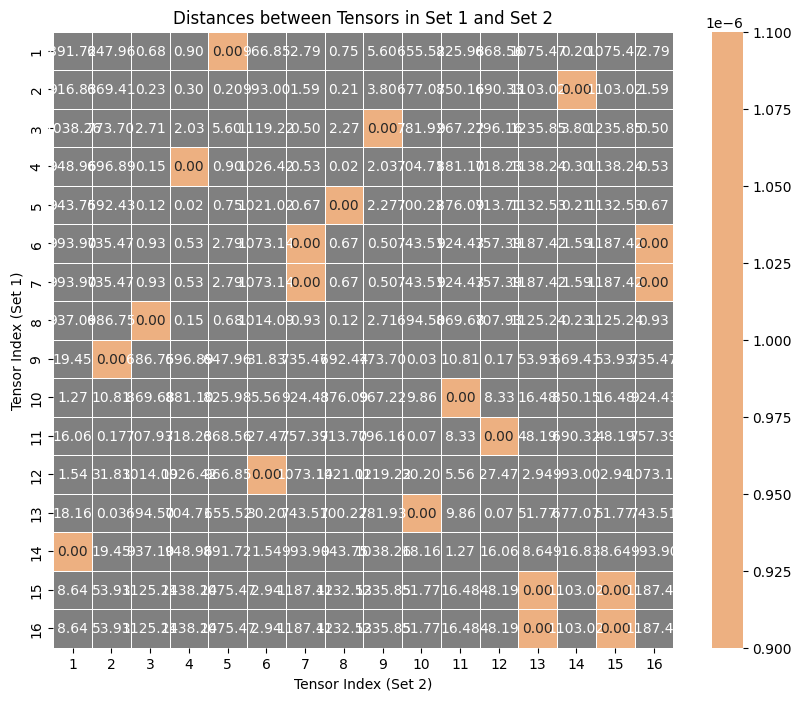

In [14]:

check_tensor_sets_with_plot(comparison_logit_set,logit_set)